# 1. Understanding the Data
Pneumonia is a very common disease. It can be either: 
- Bacterial pneumonia 
- Viral Pneumonia 
- Mycoplasma pneumonia and 
- Fungal pneumonia. 

This dataset consists pneumonia samples belonging to the first two classes. The dataset consists of only very few samples and that too unbalanced. The aim of this notebook is to develop a robust deep learning model on this limited amount of data. We all know that deep learning models are data hungry but if you know how things work, you can build good models even with a limited amount of data.


## Understanding the Stake

Machine Learning & Deep Learning has proven to be really effective in the field of heathcare. 
When it comes to healthcare, its not just a classification problem, **the stake is very high** and as a Data Scientist it is our responsiblity to make use of what minimal data we have in a best possible way.

# 2. Importing Libraries

In [1]:
import pandas
import os
import glob
import tensorflow as tf
from keras.applications import ResNet50V2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras
import os
import seaborn as sns
import cv2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report

import seaborn as sns
import glob

In [2]:
main_path = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/"


In [3]:
train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

pneumonia_train_images = glob.glob(train_path+"/FAKE/*.jpg")
normal_train_images = glob.glob(train_path+"/REAL/*.jpg")

pneumonia_test_images = glob.glob(test_path+"/FAKE/*.jpg")
normal_test_images = glob.glob(test_path+"/REAL/*.jpg")

In [4]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train_images) , [1] *  len(pneumonia_train_images)]),columns=["class"])

# 3. EDA

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Number of cases'}, xlabel='class', ylabel='count'>

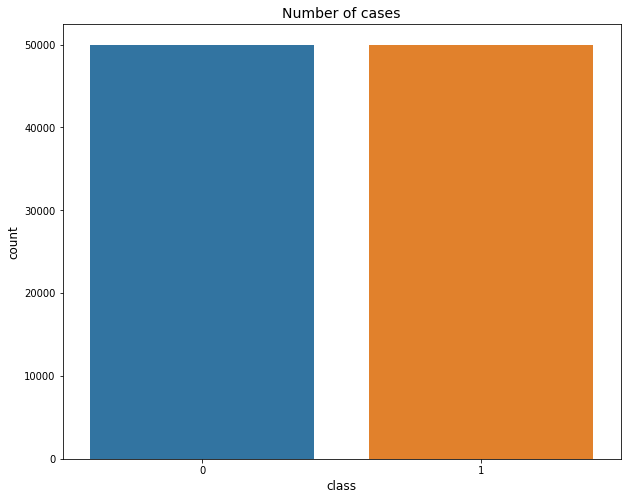

In [5]:
plt.figure(figsize=(10,8))

plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.title('Number of cases', fontsize=14)
sns.countplot(data['class'],data=data)

## Basic X-Ray images

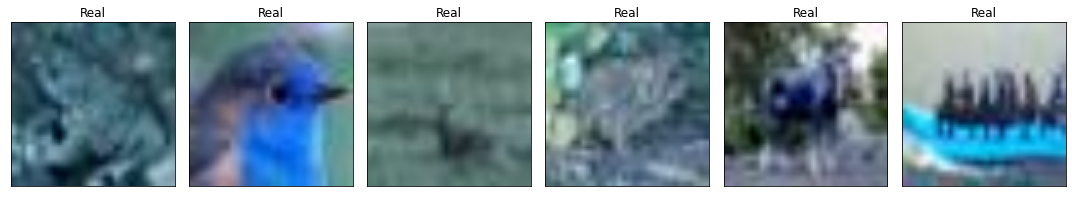

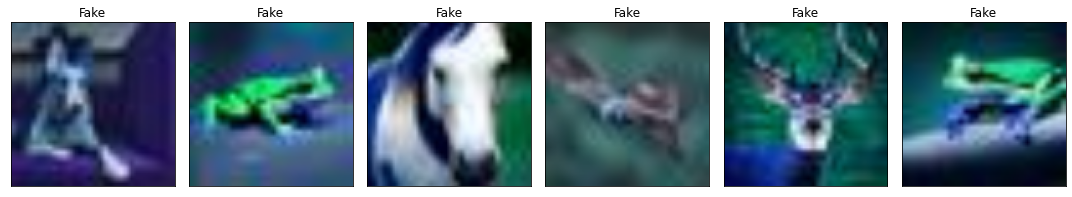

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (100,100))
    ax.imshow(img)
    ax.set_title("Real")
fig.tight_layout()    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (100,100))
    ax.imshow(img)
    ax.set_title("Fake")
fig.tight_layout()    
plt.show()

If you look carefully, then there are some cases where you won't be able to differentiate between a normal case and a pneumonia case with the naked eye. There is one case in the above plot, at least for me ,which is too much confusing. If we can build a robust classifier, it would be a great assist to the doctor too.

Let's try some other pre-processing techniques.

## Images with Canny Edges

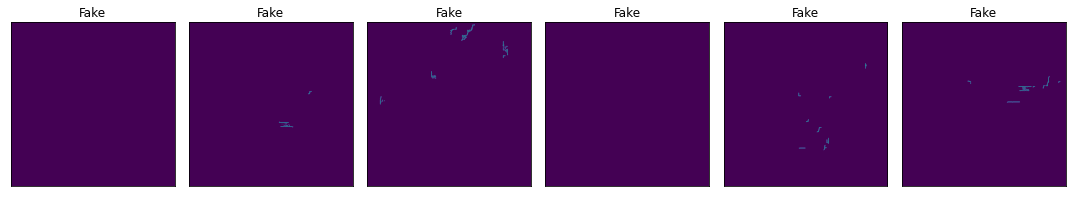

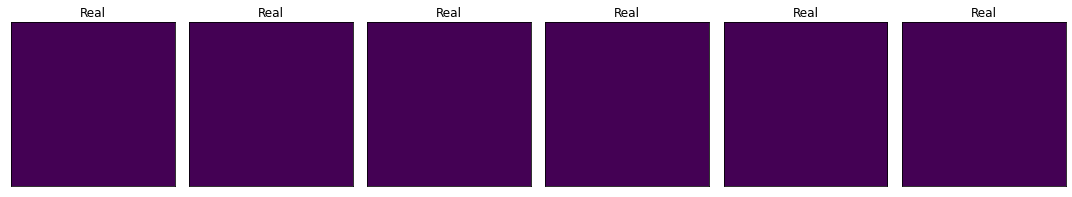

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Fake")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Real")
fig.tight_layout()    
plt.show()

We can see the Pneumonia X-ray images are quite blurry.

## Ben Graham's Method
This method involves 2 steps:
1. GrayScaling the images
2. Applying Gaussian Blur

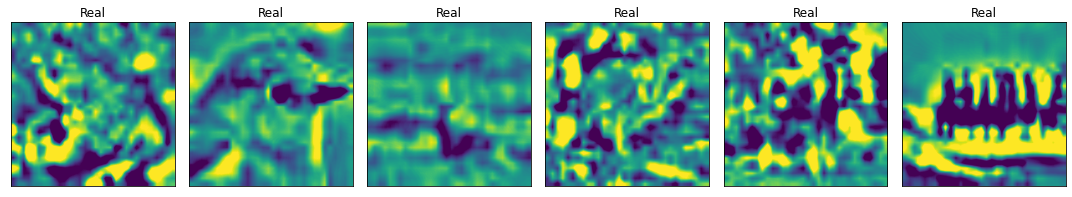

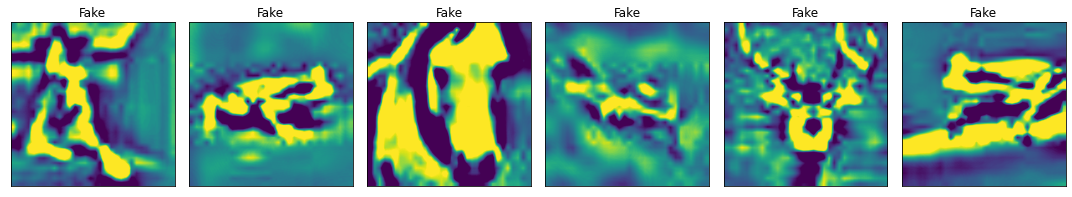

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    ax.imshow(img)
    ax.set_title("Real")
fig.tight_layout()
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    ax.imshow(img)
    ax.set_title("Fake")
fig.tight_layout()
plt.show()

We duplicated the same results with the Ben-Grahams model.

## Sobel Filter

The image is first read in as a grayscale image and converted to a matrix, then vertical and horizontal Sobel filters are applied to extract edges. Finally, we find the edge farthest from the center (approximated by the vertical center of the image) and crop vertically along this.

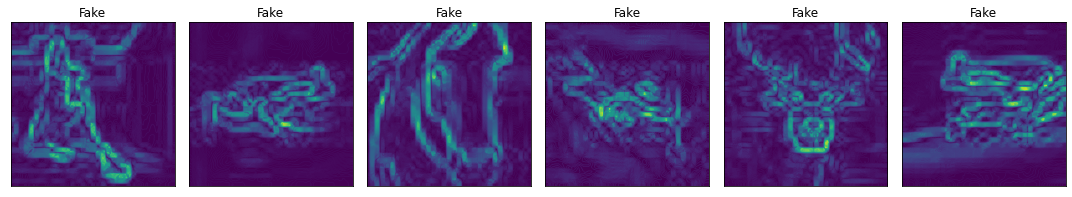

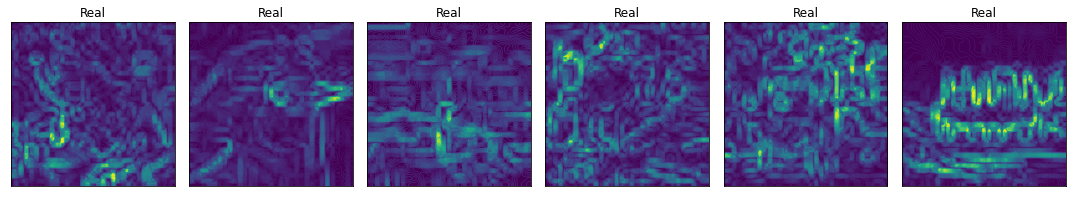

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512,512))
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(image, (11, 11), 0)
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    sobel_x = np.uint8(np.absolute(sobel_x))
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    sobel_y = np.uint8(np.absolute(sobel_y))
    edged = cv2.bitwise_or(sobel_x, sobel_y)
    ax.imshow(edged)
    ax.set_title("Fake")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (512,512))
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(image, (11, 11), 0)
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    sobel_x = np.uint8(np.absolute(sobel_x))
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    sobel_y = np.uint8(np.absolute(sobel_y))
    edged = cv2.bitwise_or(sobel_x, sobel_y)
    ax.imshow(edged)
    ax.set_title("Real")
fig.tight_layout()
plt.show()

We saw the same results with the Sobel Filter. There is definitely a pattern.

## Image Erosion

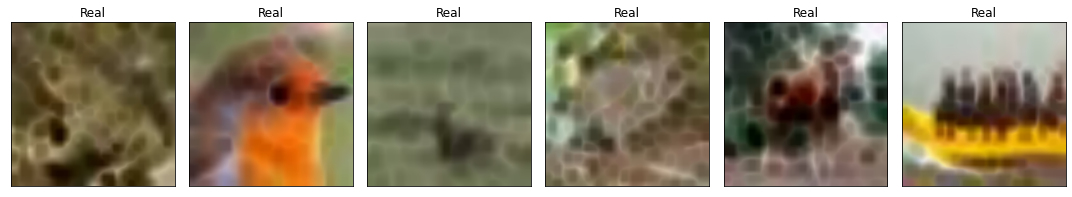

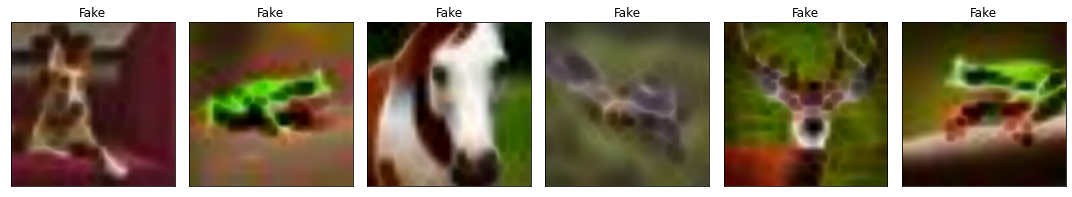

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    ax.imshow(img_erosion)
    ax.set_title("Real")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    ax.imshow(img_erosion)
    ax.set_title("Fake")
fig.tight_layout()
plt.show()

Can we see a differnce, yes we do. I think we might be able to find a good pattern among the images in the earlier layers of the model itself.

## Image Dialation

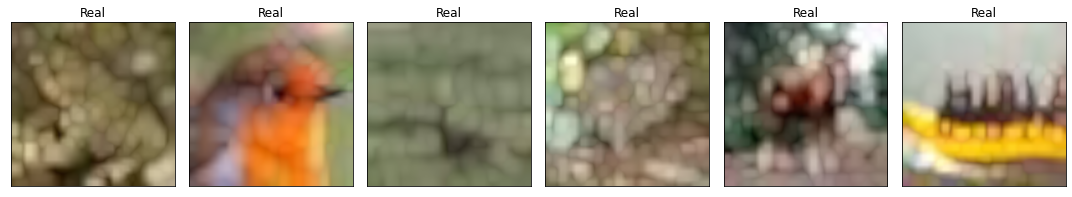

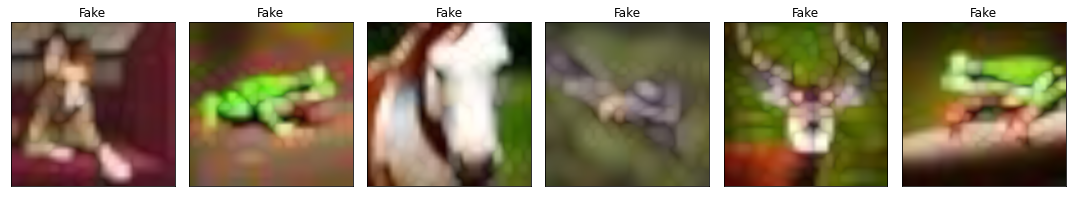

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    ax.imshow(img_erosion)
    ax.set_title("Real")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    ax.imshow(img_erosion)
    ax.set_title("Fake")
fig.tight_layout()
plt.show()

# 4. Model:
This is the best part and I suggest you to write the whole model from scratch(the basic **Convnet** worked pretty good, also the **Depthwise Separable Convnet** also worked really well). In this kernel I used transfer learning after trying out those ideas and got the best result. But also we are kaggling to learn not to implement the best model. One could also try partial transfer learning. I'll make a seprate notebook on that.

## 4.1 Data Generators with Image Augmentation

In [12]:
# define the tvalue_countse of augmentation techniques we will apply.
train_Datagen = ImageDataGenerator(
    rescale =1/255,
#     shear_range=10,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
#     rotation_range=20,
    fill_mode = 'nearest',
)
val_datagen = ImageDataGenerator(
    rescale =1/255,
#     shear_range=10,
#     zoom_range = 0.2,
#     horizontal_flip = True,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     rotation_range=20,
#     fill_mode = 'nearest',
)

In [13]:
train_generator=train_Datagen.flow_from_directory(
    train_path,
    target_size=(512,512),
    batch_size= 32,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(512,512),
    batch_size=32,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# 4.2 Creating Model (Using pre-trained resnet50 on 'image-net')

In [14]:
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu',kernel_regularizer= keras.regularizers.l2(l2=0.1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

94674944/94668760 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 23,827,201
Trainable params: 262,401
Non-trainable params: 23,564,800
_________________________________________________________________



> Keeping in mind the risk of changing the distribution of validation data, keeping that in mind I'll  be using our **Test data** as **Validation data**

In [15]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Creating LR Scheduler
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=755,
    decay_rate=0.9,
    staircase=True)

METRICS = ['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]


model.compile(optimizer= Adam(lr_schedule), loss='binary_crossentropy', metrics=METRICS)

#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_generator,
                    epochs=10,
                    steps_per_epoch = 4834 // 32,
                    validation_data = test_generator,
                    validation_steps = 624 // 32,
                    class_weight=None
                   )

Epoch 1/10
151/151 [==============================] - 309s 2s/step - loss: 7.9828 - accuracy: 0.7211 - precision: 0.7260 - recall: 0.7186 - val_loss: 0.5212 - val_accuracy: 0.8372 - val_precision: 0.8851 - val_recall: 0.7429
Epoch 2/10
151/151 [==============================] - 294s 2s/step - loss: 0.5884 - accuracy: 0.7659 - precision: 0.7668 - recall: 0.7725 - val_loss: 0.5910 - val_accuracy: 0.7286 - val_precision: 0.6617 - val_recall: 0.9811
Epoch 3/10
151/151 [==============================] - 296s 2s/step - loss: 0.5527 - accuracy: 0.7880 - precision: 0.7784 - recall: 0.7811 - val_loss: 0.4963 - val_accuracy: 0.8026 - val_precision: 0.7613 - val_recall: 0.9054
Epoch 4/10
151/151 [==============================] - 297s 2s/step - loss: 0.5583 - accuracy: 0.7827 - precision: 0.7833 - recall: 0.7645 - val_loss: 0.5503 - val_accuracy: 0.7878 - val_precision: 0.9683 - val_recall: 0.5980
Epoch 5/10
151/151 [==============================] - 296s 2s/step - loss: 0.5565 - accuracy: 0.7826

In [16]:
model.evaluate(test_generator)[1]

625/625 [==============================] - 277s 443ms/step - loss: 0.5610 - accuracy: 0.7607 - precision: 0.6854 - recall: 0.9641


0.7607499957084656

In [17]:
for layer in base_model.layers[:165]:
    layer.trainable = False
for layer in base_model.layers[165:]:
    layer.trainable = True

# 5. Finetuning the Model: 
Finetuning is an art when it comes to Machine Learning, and there are many ways to adjust the model in efforts to improve it. Finetuning is beyond the scope of this notebook, but check out this [article](https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/) for more information.

For our purposes, we'll use Keras callbacks to further finetune our model. The checkpoint callback saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it. The early stopping callback stops the training process when the model starts becoming stagnant, or even worse, when the model starts overfitting. Since we set restore_best_weights to True, the returned model at the end of the training process will be the model with the best weights (i.e. low loss and high accuracy).

In [18]:
# Learning Rate
initial_learning_rate = 1e-5

# Learning Rate Scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=755,
    decay_rate=0.9,
    staircase=True)


model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),  # Very slow learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [19]:
history_new = model.fit(train_generator,
                        epochs=20,
                        steps_per_epoch = 4834 // 32,
                        validation_data = test_generator,
                        validation_steps = 624 // 32,
                        )

Epoch 1/20
151/151 [==============================] - 305s 2s/step - loss: 0.5347 - accuracy: 0.7911 - precision: 0.6956 - recall: 0.9468 - val_loss: 0.6124 - val_accuracy: 0.8289 - val_precision: 0.7487 - val_recall: 0.9692
Epoch 2/20
151/151 [==============================] - 294s 2s/step - loss: 0.3477 - accuracy: 0.8722 - precision: 0.8711 - recall: 0.8710 - val_loss: 0.2587 - val_accuracy: 0.9293 - val_precision: 0.9343 - val_recall: 0.9184
Epoch 3/20
151/151 [==============================] - 284s 2s/step - loss: 0.3098 - accuracy: 0.8955 - precision: 0.9034 - recall: 0.8878 - val_loss: 0.2137 - val_accuracy: 0.9211 - val_precision: 0.9382 - val_recall: 0.8836
Epoch 4/20
151/151 [==============================] - 281s 2s/step - loss: 0.2771 - accuracy: 0.9060 - precision: 0.9120 - recall: 0.8959 - val_loss: 0.3349 - val_accuracy: 0.8865 - val_precision: 0.8390 - val_recall: 0.9612
Epoch 5/20
151/151 [==============================] - 282s 2s/step - loss: 0.2440 - accuracy: 0.9158

# 6. Visualizing Model Performance

In [20]:
accuracy = history_new.history['accuracy']
val_accuracy  = history_new.history['val_accuracy']

loss = history_new.history['loss']
val_loss = history_new.history['val_loss']

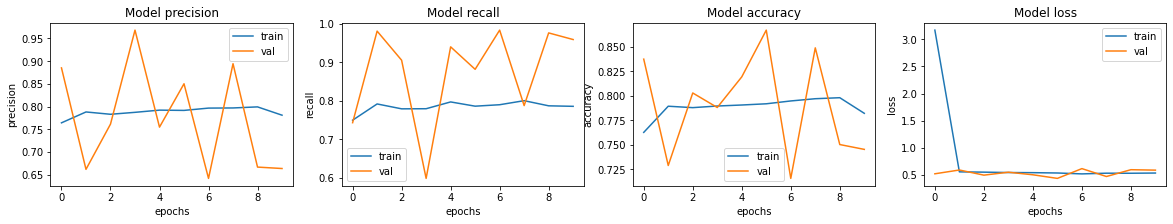

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


# 7. Predicting and Evaluating Results

In [22]:
model.evaluate(test_generator)[1]

625/625 [==============================] - 277s 442ms/step - loss: 0.1478 - accuracy: 0.9505 - precision: 0.9559 - recall: 0.9445


0.9504500031471252

In [23]:
y_true=test_generator.classes[test_generator.index_array]  

In [24]:
y_pred = np.squeeze(model.predict_classes(test_generator))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [25]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10000
           1       0.96      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



<AxesSubplot:>

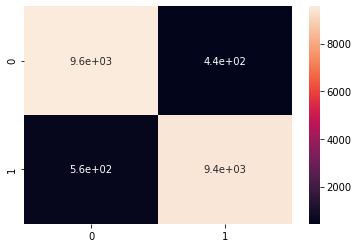

In [26]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_true,y_pred),annot=True)

In [27]:
cm = confusion_matrix(y_true,y_pred)

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))


Recall of the model is 0.94
Precision of the model is 0.96
